In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import os
import sys
sys.path.append('../')
#from models.unet3d import EncoderModelGenesis
import torch
import torchvision.models as models
import matplotlib.patches as patches
import torchvision.models as tvmodels
from torch.utils.data.dataset import Dataset
import os
import pandas as pd
from py_jotools import augmentation, mut
import numpy as np
import nibabel as nib
import torch
import pydicom as pyd
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mperkonigg/.local/lib/python3.6/site-packages/m

In [5]:
seed = 516165

In [7]:
df_dsinfo = pd.read_csv('/data/dataset/external/MandMs/201014_M&Ms_Dataset_Information_-_opendataset.csv')

In [8]:
df_dsinfo

,External code,VendorName,Vendor,Centre,ED,ES
0,A0S9V9,Siemens,A,1,0,9
1,A1D0Q7,Philips,B,2,0,9
2,A1D9Z7,Siemens,A,1,22,11
3,A1E9Q1,Siemens,A,1,0,9
4,A1K2P5,Canon,D,5,33,11
...,...,...,...,...,...,...
340,T2Z1Z9,Canon,D,5,29,9
341,T9U9W2,Siemens,A,1,0,10
342,V4W8Z5,GE,C,4,19,9
343,W5Z4Z8,Philips,B,2,29,11


In [ ]:
df_dsinfo['labels'] = True

for p in glob('/home/mperkonigg/Documents/ExternalData/MandMs/Training/Unlabeled/*'):
    df_dsinfo.loc[df_dsinfo['External code']==p.split('/')[-1], 'labels'] = False

In [21]:
def gram_matrix_3d(input, pool_factor=1):
    # taken from: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
    a, b, c, d, e = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    grams = []

    for i in range(a):
        features = input[i].view(b, c * d * e)  # resise F_XL into \hat F_XL
        G = torch.mm(features, features.t())  # compute the gram product
        if pool_factor==1:
            grams.append(G.div(b * c * d * e))
        else:
            pool = nn.MaxPool2d(pool_factor)
            gram = G.div(b * c * d * e)
            gram_pooled = pool(gram[None, :])
            grams.append(gram_pooled[0])

    return grams

def gram_hook(m, input, output):
    grammatrices.append(gram_matrix_3d(input[0]))

def register_hooks():
    for layer in gramlayers:
        layer.register_forward_hook(gram_hook)
        
        
class NiiDataset(Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def load_image(self, excode, t):
        img = nib.load(f'/data/dataset/external/MandMs/nifti/{excode}/{excode}_sa.nii.gz')
        img = img.get_fdata()[:, :, :, t]
        img = mut.norm01(img)

        # return img[None, :, :]
        return img

    def __getitem__(self, index):
        elem = self.df.iloc[index]
        img = self.load_image(elem['External code'], t=elem.ED)
        return torch.as_tensor(img, dtype=torch.float32), elem.VendorName

In [22]:
device = torch.device('cuda')

stylemodel = EncoderModelGenesis()

#Load pretrained model genesis
weight_dir = '../models/Genesis_Chest_CT.pt'
checkpoint = torch.load(weight_dir)
state_dict = checkpoint['state_dict']
unParalled_state_dict = {}
for key in state_dict.keys():
    if key.startswith('module.down_'):
        unParalled_state_dict[key.replace("module.", "")] = state_dict[key]
stylemodel.load_state_dict(unParalled_state_dict)


stylemodel = stylemodel.to(device)
stylemodel.eval()

grammatrices = []
gramlayers = [stylemodel.down_tr64.ops[1].conv1]

register_hooks()
collected_matrices = {}

In [28]:
ds = NiiDataset(df_dsinfo.loc[df_dsinfo.labels==True])
dl = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=4, pin_memory=True)

In [33]:
matrices_for_embedding = []
grammatrices = []
scanners = []

for batch in dl:
    image, scanner = batch

    x = image[None, :, :, :, :].to(device)
    if x.shape[-1]>=8:
        y_style = stylemodel(x.float())
        for gm in grammatrices[0]:
            matrices_for_embedding.append(gm.detach().cpu().numpy().flatten())
        scanners.append(scanner)
        grammatrices = []

In [34]:
tsne = TSNE(n_components=2, perplexity=50)
elements_tsne = tsne.fit_transform(matrices_for_embedding)

In [37]:
df_dsinfo.VendorName.unique()

array(['Siemens', 'Philips', 'Canon', 'GE'], dtype=object)

In [43]:
i_scanners = []
for s in scanners:
    if s[0]=='Siemens':
        i_scanners.append(0)
    elif s[0]=='GE':
        i_scanners.append(1)
    elif s[0]=='Canon':
        i_scanners.append(2)
    elif s[0]=='Philips':
        i_scanners.append(3)

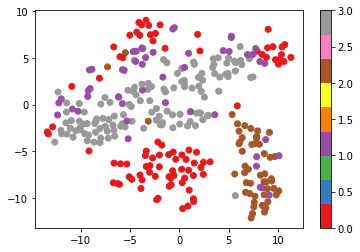

In [44]:
plt.scatter(elements_tsne[:, 0], elements_tsne[:, 1], c=i_scanners, cmap='Set1')
plt.colorbar()

In [46]:
df_dsinfo.groupby(['VendorName', 'Centre']).count()

External code  Vendor  ED  ES  labels
VendorName Centre                                       
Canon      5                  50      50  50  50      50
GE         4                  75      75  75  75      75
Philips    2                  74      74  74  74      74
           3                  51      51  51  51      51
Siemens    1                  95      95  95  95      95

In [49]:
df_dsinfo = df_dsinfo.loc[df_dsinfo.labels]

In [52]:
df_dsinfo.groupby(['VendorName', 'Centre']).count()

External code  Vendor  ED  ES  labels
VendorName Centre                                       
Canon      5                  50      50  50  50      50
GE         4                  50      50  50  50      50
Philips    2                  74      74  74  74      74
           3                  51      51  51  51      51
Siemens    1                  95      95  95  95      95

In [114]:
df_base = df_dsinfo.loc[df_dsinfo.VendorName=='Siemens']
df_base = df_base.sample(frac=1.0, random_state=seed).reset_index(drop=True)
df_base['split'] = 'None'
df_base.iloc[0:50].split='base'
df_base.iloc[50:75].split='train'
df_base.iloc[75:85].split='val'
df_base.iloc[85:].split='test'

df_phil = df_dsinfo.loc[df_dsinfo.VendorName=='Philips']
df_phil = df_phil.sample(frac=1.0, random_state=seed).reset_index(drop=True)
df_phil['split'] = 'None'
df_phil.iloc[0:105].split='train'
df_phil.iloc[105:115].split='val'
df_phil.iloc[115:].split='test'

df_ge = df_dsinfo.loc[df_dsinfo.VendorName=='GE']
df_ge = df_ge.sample(frac=1.0, random_state=seed).reset_index(drop=True)
df_ge['split'] = 'None'
df_ge.iloc[0:30].split='train'
df_ge.iloc[30:40].split='val'
df_ge.iloc[40:].split='test'

df_canon = df_dsinfo.loc[df_dsinfo.VendorName=='Canon']
df_canon = df_canon.sample(frac=1.0, random_state=seed).reset_index(drop=True)
df_canon['split'] = 'None'
df_canon.iloc[0:30].split='train'
df_canon.iloc[30:40].split='val'
df_canon.iloc[40:].split='test'

df_train = pd.concat([df_base, df_phil, df_ge, df_canon])
df_train.groupby(['VendorName', 'split']).count()
df_train.to_csv('/project/catinous/cardiac_patient_split.csv', index=False)

/home/mperkonigg/.local/lib/python3.6/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [118]:
scanners = []
imgs = []
ts = []
slices = []
splits = []
for i, row in df_train.iterrows():
    excode = row['External code']
    filepath = f'/data/dataset/external/MandMs/nifti/{excode}/{excode}_sa.nii.gz'
    img = nib.load(filepath)
    sl = img.shape[2]
    
    slices.extend(list(range(0, sl)))
    imgs.extend([filepath]*sl)
    ts.extend([row.ED]*sl)
    scanners.extend([row.VendorName]*sl)
    splits.extend([row.split]*sl)
    
    slices.extend(list(range(0, sl)))
    imgs.extend([filepath]*sl)
    ts.extend([row.ES]*sl)
    scanners.extend([row.VendorName]*sl)
    splits.extend([row.split]*sl)
    
df_train_slices = pd.DataFrame({'scanner': scanners, 'filepath':imgs, 't': ts, 'slice': slices, 'split': splits})

In [125]:
df_train_slices.to_csv('/project/catinous/cardiac_slices_split.csv', index=False)

In [6]:
pd.read_csv('/project/catinous/cardiacslicessplit.csv')

,scanner,filepath,t,slice,split
0,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,0,base
1,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,1,base
2,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,2,base
3,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,3,base
4,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,4,base
...,...,...,...,...,...
7315,Canon,/data/dataset/external/MandMs/nifti/N7P3T8/N7P...,10,9,test
7316,Canon,/data/dataset/external/MandMs/nifti/N7P3T8/N7P...,10,10,test
7317,Canon,/data/dataset/external/MandMs/nifti/N7P3T8/N7P...,10,11,test
7318,Canon,/data/dataset/external/MandMs/nifti/N7P3T8/N7P...,10,12,test


In [4]:
df = pd.read_csv('/project/catinous/cardiacslicessplit.csv')
df

,scanner,filepath,t,slice,split
0,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,0,base
1,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,1,base
2,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,2,base
3,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,3,base
4,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,4,base
...,...,...,...,...,...
7315,Canon,/data/dataset/external/MandMs/nifti/N7P3T8/N7P...,10,9,test
7316,Canon,/data/dataset/external/MandMs/nifti/N7P3T8/N7P...,10,10,test
7317,Canon,/data/dataset/external/MandMs/nifti/N7P3T8/N7P...,10,11,test
7318,Canon,/data/dataset/external/MandMs/nifti/N7P3T8/N7P...,10,12,test


In [6]:
df = pd.read_csv('/project/catinous/cardiacslicessplitsingle.csv')
df.iloc[0].filepath

'/data/dataset/external/MandMs/nifti/D4M3Q2/D4M3Q2_sa.nii.gz'

In [7]:
df.iloc[0].slicepath

'/project/catinous/cardiac_data/singleSlices/D4M3Q2_sa/0_0.npy'

In [2]:
threshold = 20
self.force_element = lambda m : m < threshold
check_force_lidc  = lambda m : m > threshold

In [5]:
check_force_cardiac(15)

True

In [6]:
check_force_lidc(15)

False

In [7]:
def add(x, y):
    return x+y

In [8]:
add(4, 3)

7

In [9]:
addanother = add

In [11]:
addanother(4, 4)

8